# <h1><center>Prediction of Failure in Steel Frames</center></h1>

<h4 align="center">Erika Yeonseo Park: ypark258@wisc.edu</h4> 
<h4 align="center">Jina Yang: jyang633@wisc.edu</h4> 
<h4 align="center">Hyeyoung Koh: hyeyoung.koh@wisc.edu</h4> 



## 1. Preprocessing 

### 1.1. Load Dataset  &  Data Scaling 

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from mlxtend.evaluate import PredefinedHoldoutSplit
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from mlxtend.evaluate import bootstrap_point632_score

from sklearn.pipeline import Pipeline

from sklearn.neighbors import KDTree


In [43]:
# assigning names to feature variable and class label for each dataset
raw_data_1 = pd.read_csv('data/raw_dataset_1.csv') # frame 1 
raw_data_2 = pd.read_csv('data/raw_dataset_2.csv') # frame 2

#creating lists for column names
raw_data_1.columns = ['Dead load (kN/m)', 'Live load (kN/m)', 'Yield strength (MPa)', 'Elastic modulus (MPa)', 'Sway imperfection', 'Residual stress', 'Lambda', 'Class']
raw_data_2.columns = ['Dead load (kN/m)', 'Live load (kN/m)', 'Yield strength (MPa)', 'Elastic modulus (MPa)', 'Sway imperfection', 'Residual stress', 'Lambda', 'Class']

#nominal values
D_1 = 31.0722; L_1 = 46.6083;D_2 = 30.4028;L_2 = 45.6042; Fy = 248;E = 200000;oop = 1/700;rs = 1.064;

#normalized data
data_1 = raw_data_1.div([D_1, L_1, Fy, E, oop, rs, 1, 1])
data_2 = raw_data_2.div([D_2, L_2, Fy, E, oop, rs, 1, 1])

### 1.2. Plot Dataset 

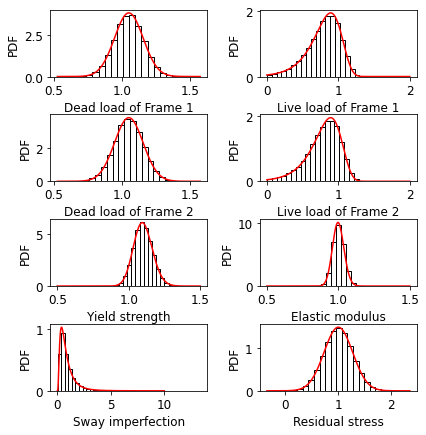

In [44]:
import matplotlib.pyplot as plt
from scipy import stats

fig, axs = plt.subplots(4,2, figsize=(6,6))
plt.subplots_adjust(bottom=0.1, right=0.9, left = 0.1, top=0.9, hspace=0.95, wspace=0.2)

plt.tight_layout()

# histogram of Dead load of Frame 1
X0 = data_1.iloc[:,0];
mu, sigma = stats.norm.fit(X0)
x = np.linspace(mu - 5*sigma, mu + 5*sigma, len(X0))

axs[0,0].hist(X0, bins=20, ec='black', density=True, color="white");
axs[0,0].plot(x, stats.norm.pdf(x,mu,sigma), color="red")
axs[0,0].set_xlabel('Dead load of Frame 1')
axs[0,0].set_ylabel('PDF');

# histogram of Live load of Frame 1
X1 = data_1.iloc[:,1];
loc, scale = stats.gumbel_l.fit(X1)
x = np.linspace(0, 2, len(X1))
pdf = stats.gumbel_l.pdf(x,loc,scale)

axs[0,1].hist(X1, bins=20, ec='black', density=True, color="white");
axs[0,1].plot(x, pdf, color="red")
axs[0,1].set_xlabel('Live load of Frame 1');
axs[0,1].set_ylabel('PDF');

# histogram of Dead load of Frame 2
X0 = data_2.iloc[:,0];
mu, sigma = stats.norm.fit(X0)
x = np.linspace(mu - 5*sigma, mu + 5*sigma, len(X0))

axs[1,0].hist(X0, bins=20, ec='black', density=True, color="white");
axs[1,0].plot(x, stats.norm.pdf(x,mu,sigma), color="red")
axs[1,0].set_xlabel('Dead load of Frame 2')
axs[1,0].set_ylabel('PDF');

# histogram of Live load of Frame 2
X1 = data_2.iloc[:,1];
loc, scale = stats.gumbel_l.fit(X1)
x = np.linspace(0, 2, len(X1))
pdf = stats.gumbel_l.pdf(x,loc,scale)

axs[1,1].hist(X1, bins=20, ec='black', density=True, color="white");
axs[1,1].plot(x, pdf, color="red")
axs[1,1].set_xlabel('Live load of Frame 2');
axs[1,1].set_ylabel('PDF');

# histogram of Fy
X2 = data_1.iloc[:,2];
shape, loc, scale = stats.lognorm.fit(X2, floc=0)
x = np.linspace(0.5, 1.5, len(X2))
pdf = stats.lognorm.pdf(x,shape,loc,scale)

axs[2,0].hist(X2, bins=20, ec='black', density=True, color="white");
axs[2,0].plot(x, pdf, color="red")
axs[2,0].set_xlabel('Yield strength');
axs[2,0].set_ylabel('PDF');

# histogram of E
X3 = data_1.iloc[:,3];
shape, loc, scale = stats.lognorm.fit(X3, floc=0)
x = np.linspace(0.5,1.5, len(X3))
pdf = stats.lognorm.pdf(x,shape,loc,scale)

axs[2,1].hist(X3, bins=10, ec='black', density=True, color="white");
axs[2,1].plot(x, pdf, color="red")
axs[2,1].set_xlabel('Elastic modulus');
axs[2,1].set_ylabel('PDF');

# histogram of sway imperfection
X4 = data_1.iloc[:,4];
shape, loc, scale = stats.lognorm.fit(X4, floc=0)
x = np.linspace(0.,10, len(X4))
pdf = stats.lognorm.pdf(x,shape,loc,scale)

axs[3,0].hist(X4, bins=40, ec='black', density=True, color="white");
axs[3,0].plot(x, pdf, color="red")
axs[3,0].set_xlabel('Sway imperfection');
axs[3,0].set_ylabel('PDF');

# histogram of residual stress
X5 = data_1.iloc[:,5];
mu, sigma = stats.norm.fit(X5)
x = np.linspace(mu - 5*sigma, mu + 5*sigma, len(X5))

axs[3,1].hist(X5, bins=20, ec='black', density=True, color="white");
axs[3,1].plot(x, stats.norm.pdf(x,mu,sigma), color="red")
axs[3,1].set_xlabel('Residual stress');
axs[3,1].set_ylabel('PDF');
plt.rcParams.update({'font.size': 12})
plt.savefig('rv.png', dpi=600)

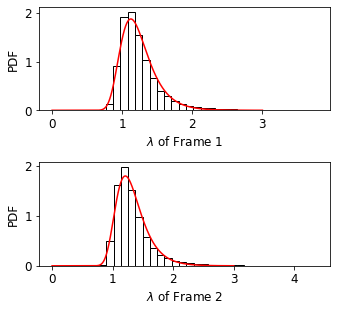

In [45]:
fig, axs = plt.subplots(2,1, figsize=(6,6))
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.7, hspace=0.5)
# plt.tight_layout()

# histogram of lambda of Frame 1
X6 = data_1.iloc[:,6];
loc, scale = stats.gumbel_r.fit(X6)
x = np.linspace(0,3, len(X6))
pdf = stats.gumbel_r.pdf(x,loc,scale)

axs[0].hist(X6, bins=30, ec='black', density=True, color = "white");
axs[0].plot(x, pdf, color="red")
axs[0].set_xlabel('$\lambda$ of Frame 1');
axs[0].set_ylabel('PDF');

# histogram of lambda of Frame 2
X7 = data_2.iloc[:,6];
loc, scale = stats.gumbel_r.fit(X7)
x = np.linspace(0,3, len(X7))
pdf = stats.gumbel_r.pdf(x,loc,scale)

axs[1].hist(X7, bins=30, ec='black', density=True, color="white");
axs[1].plot(x, pdf, color="red")
axs[1].set_xlabel('$\lambda$ of Frame 2');
axs[1].set_ylabel('PDF');
plt.rcParams.update({'font.size': 12})
plt.savefig('lam.png', dpi=600)

### 1.3. Splitting Dataset 

In [7]:
#Separating the features and class label

features = ['Dead load (kN/m)', 'Live load (kN/m)', 'Yield strength (MPa)', 'Elastic modulus (MPa)', 'Sway imperfection', 'Residual stress']
X = data_1[features].values 
y = data_1[['Class']].values
y = y.ravel()

#Spliting data 1 into training(75%) and test set (25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                test_size=0.25,
                                                    random_state=123,
                                                    shuffle=True,
                                                    stratify=y)

print('Train/Test sizes:', X_train.shape, y_test.shape)

Train/Test sizes: (37081, 6) (12361,)


### 1.4. Dimensionality Reduction

#### Principal Component Analysis (PCA)
Before the hyperparameter tuning and model se- lection, standardization and feature selection are employed to be used for k-Nearest Neighbor algorithm.

In [8]:
#scailing 
scaler = StandardScaler()
X_train_scaled = scaler.fit(X_train).transform(X_train)
X_test_scaled = scaler.fit(X_test).transform(X_test)
X_scaled = scaler.fit(X).transform(X)

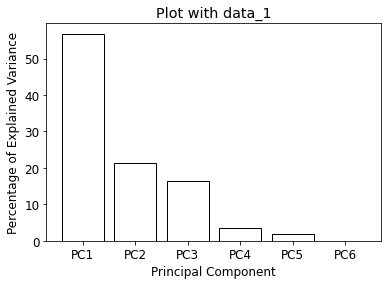

[56.8 21.4 16.5  3.5  1.8  0. ]


<Figure size 432x288 with 0 Axes>

In [9]:
data = X 

scaled = StandardScaler().fit_transform(data.T) 

pca = PCA() 
pca.fit(scaled) 
pca_data = pca.transform(scaled) #generating coordinates for a PCA graph based on the loading scores and the scaled data 

#Calculating the percentage of variation that each principal component accounts for 
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ['PC'+ str(x) for x in range(1, len(per_var) +1)]

plt.rcParams.update({'font.size': 12})
plt.bar(x=range(1, len(per_var) +1), height=per_var, tick_label=labels, color = 'white', ec= 'black')
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Plot with data_1')
plt.show() 
plt.savefig('pca_var.png', dpi=600)

print(per_var)

In [11]:
pca = PCA(n_components=3)
fit = pca.fit(X_train)
print("Explained Variance: %s" % fit.explained_variance_ratio_)
print(fit.components_)
# Values with higher variance portrays the dataset better.

Explained Variance: [0.82077439 0.09180767 0.06609835]
[[ 6.40759941e-04  2.20835744e-03 -1.29931666e-04 -7.98137912e-05
   9.99996934e-01  9.06653569e-04]
 [ 1.95473927e-03  3.86740052e-03  1.97224781e-03  1.58182714e-03
  -9.16055199e-04  9.99986995e-01]
 [-2.21482791e-03 -9.99982631e-01  2.51130696e-03  1.92687831e-03
   2.20672023e-03  3.86573360e-03]]


#### Feature Selection
Based on the number of important features that are checked through PCA, the best features among the six features are selected by the use of simple sequential forward selec- tion.

In [12]:
knn = KNeighborsClassifier(n_neighbors=3)

#simple sequential forward selection 
sfs1 = SFS(knn, 
           k_features=3, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=0)

sfs1 = sfs1.fit(X, y)
sfs1.subsets_
# Checking index [0,1,5] has the highest sequential feature selection score 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.9s finished

[2020-12-16 21:26:00] Features: 1/3 -- score: 0.9223736903846932[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.7s finished

[2020-12-16 21:26:04] Features: 2/3 -- score: 0.9409004490109624[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.9s finished

[2020-12-16 21:26:08] Features: 3/3 -- score: 0.952510011730917

{1: {'feature_idx': (1,),
  'cv_scores': array([0.92237369]),
  'avg_score': 0.9223736903846932,
  'feature_names': ('1',)},
 2: {'feature_idx': (1, 5),
  'cv_scores': array([0.94090045]),
  'avg_score': 0.9409004490109624,
  'feature_names': ('1', '5')},
 3: {'feature_idx': (0, 1, 5),
  'cv_scores': array([0.95251001]),
  'avg_score': 0.952510011730917,
  'feature_names': ('0', '1', '5')}}

In [13]:
# Checking the name of the features that will be used for k-NN. 
ary = np.array(features)
idx = [0,1,5]
print(ary[idx])

# Assigning new names for training & test set with chosen features on the scaled data 
X_train_1 = X_train_scaled[:, [0,1,5]]
X_test_1 = X_test_scaled[:, [0,1,5]]

['Dead load (kN/m)' 'Live load (kN/m)' 'Residual stress']


## 2. Model Selection 

In [15]:
# Initializing Classifiers
clf1 = KNeighborsClassifier()   
clf2 = DecisionTreeClassifier(random_state=123) # don't need to scale the parameters
clf3 = RandomForestClassifier(random_state=123, n_estimators = 1000) #don't need to scale the parmeters 

# Setting up the parameter grids
#kNN 
param_grid1 = [{'n_neighbors': list(range(3,15)),
               'p': [1, 2], #1: Manhattan, 2: euclidean 
               'algorithm':['auto', 'kd_tree', 'ball_tree']}]
#Decision Tree 
param_grid2 = [{'max_depth': list(range(1, 20)) + [None],  
                'criterion': ['gini', 'entropy'],
                'min_samples_split': [2, 3, 4]}]
#Random Forest 
param_grid3 = [{'max_depth': [1, 3, 11, 13, None],
               'min_samples_split': [2, 3]}] 

In [16]:
#Innner loop
gridcvs = {}
inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=123) #2 inner fold (5 outter fold)

for pgrid, est, name  in zip((param_grid1, param_grid2, param_grid3), #parameter gird
                            (clf1, clf2, clf3),  #classifier
                            ('KNN', 'DecisionTree','RandomForest')): #its name
    
    gcv = GridSearchCV(estimator=est,   
                       param_grid=pgrid,
                       scoring='accuracy',
                       n_jobs=None,
                       cv=inner_cv,  
                       verbose=0,
                       refit=True)
    gridcvs[name] = gcv   

In [17]:
#Outer loop
for (name, gs_est), X_train in zip((gridcvs.items()),(X_train_1, X_train, X_train)):

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    outer_scores = [] #collect the score for test fold.
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123) # 5 outer loop 
    for train_idx, valid_idx in outer_cv.split(X_train, y_train):
        gridcvs[name].fit(X_train[train_idx], y_train[train_idx]) 
        print('\n        Best ACC (avg. of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        outer_scores.append(gridcvs[name].best_estimator_.score(X_train[valid_idx], y_train[valid_idx]))
        print('        ACC (on outer test fold) %.2f%%' % (outer_scores[-1]*100))
    print('\n    Outer Loop:')
    print('        ACC %.2f%% +/- %.2f' % 
              (np.mean(outer_scores) * 100, np.std(outer_scores) * 100))  #avg over the test fold from outer fold


-------------------------------------------------- 

Algorithm: KNN
    Inner loop:

        Best ACC (avg. of inner test folds) 92.78%
        Best parameters: {'algorithm': 'auto', 'n_neighbors': 11, 'p': 1}
        ACC (on outer test fold) 93.07%

        Best ACC (avg. of inner test folds) 92.83%
        Best parameters: {'algorithm': 'auto', 'n_neighbors': 12, 'p': 2}
        ACC (on outer test fold) 92.83%

        Best ACC (avg. of inner test folds) 92.95%
        Best parameters: {'algorithm': 'auto', 'n_neighbors': 14, 'p': 2}
        ACC (on outer test fold) 92.50%

        Best ACC (avg. of inner test folds) 92.86%
        Best parameters: {'algorithm': 'auto', 'n_neighbors': 13, 'p': 2}
        ACC (on outer test fold) 92.69%

        Best ACC (avg. of inner test folds) 92.74%
        Best parameters: {'algorithm': 'auto', 'n_neighbors': 14, 'p': 2}
        ACC (on outer test fold) 93.18%

    Outer Loop:
        ACC 92.85% +/- 0.25
-----------------------------------------

The algorithm with the highest average accuracy appears to be **Random Forest**. However, the decision tree performs sufficiently well and the difference between the decision tree and random forest accuracy is not very significant. It is necessary to compare them again.

## 3. Algorithm Selection

10-fold Cross Validation to compare **Decision Tree** and **Random Forest**

In [18]:
for i, clf, param_grid in zip((2,3),(clf2, clf3),(param_grid2, param_grid3)):
    gcv_model_select_i = GridSearchCV(estimator=clf,
                                    param_grid=param_grid,
                                    scoring='accuracy',
                                    n_jobs=None,
                                    cv=10,
                                    verbose=1,
                                    refit=True)
    gcv_model_select_i.fit(X_train, y_train)
    print('Best CV accuracy: %.2f%%' % (gcv_model_select_i.best_score_*100),',   Best parameters:', gcv_model_select_i.best_params_ )

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best CV accuracy: 95.43% ,   Best parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 4}
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 51.1min finished


Best CV accuracy: 97.54% ,   Best parameters: {'max_depth': None, 'min_samples_split': 2}


## 4. Evaluation

To evaluate the chosen algorithm and model, bootstrapping is run on training set with the best hyper parameter setting. Then, the model is fitted on the training set and is evaluated on the test set.

In [22]:
#0.632 bootstrap method on the training set
model = gcv.best_estimator_   
bootstrap_scores = bootstrap_point632_score(model, 
                                            X_train, y_train, 
                                            n_splits=200,
                                            random_seed=123)


lower = np.percentile(bootstrap_scores, 2.5)
upper = np.percentile(bootstrap_scores, 97.5)

print('Score Std', np.std(bootstrap_scores))
print('Mean Bootstrap score', np.mean(bootstrap_scores)*100,'%')
print('95%% Confidence interval: [%.2f, %.2f]' % (100*lower, 100*upper))

Score Std 0.0009270480559164834
Mean Bootstrap score 98.32570267209076 %
95% Confidence interval: [98.16, 98.51]


In [23]:
#Fit on training & Evaluating on test set 
model = gcv.best_estimator_   
model.fit(X_train, y_train)

train_acc = accuracy_score(y_true=y_train, y_pred=model.predict(X_train))
test_acc = accuracy_score(y_true=y_test, y_pred=model.predict(X_test))

print('Training Accuracy: %.2f%%' % (100 * train_acc))
print('Test Accuracy: %.2f%%' % (100 * test_acc))

Training Accuracy: 100.00%
Test Accuracy: 97.77%


In [25]:
# Reconfirmation: Using the whole dataset to evaluate
forest = RandomForestClassifier(n_estimators=1000,
                                max_depth=None,
                                min_samples_split=3,
                                random_state=1)
forest.fit(X, y)

#Fitting it on the whole dataset 
cv_acc = cross_val_score(estimator= forest,
                         X= X,
                         y= y,
                         cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                         n_jobs=-1)
print('Kfold Accuracy: %.2f%%' % (np.mean(cv_acc)*100))

Kfold Accuracy: 97.76%


## 5. Experiments

### 5.1.Experiments with the Three Models

#### 5.1.1. $k$NN 
Best model for $k$NN with tuned hyperparameters: {'algorithm': 'auto', 'n_neighbors': 15, 'p': 2} from nested cross validation.

In [26]:
knn = KNeighborsClassifier(n_neighbors=15,
                          algorithm='auto', 
                          p=2)

knn.fit(X_train_1, y_train)

print('Test set accuracy: ', knn.score(X_test_1, y_test)*100)   

Test set accuracy:  93.2691529811504


[0.9191003964080576, 0.9165925086967074, 0.9258959631097807, 0.9233880753984306, 0.9271094571636599, 0.926947657956476, 0.9292128468570504, 0.9292937464606423, 0.9309926381360731, 0.931154437343257, 0.9321252325863604, 0.9330960278294637, 0.9326915298115039]


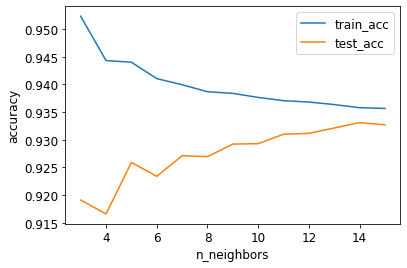

In [27]:
##  Plot 
training_accuracy = []
test_accuracy = []
neighbors_settings = range(3,16)

for n_neighbors in neighbors_settings:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto', p=2)
    clf.fit(X_train_1, y_train)   
    # accuracy of training set
    training_accuracy.append(clf.score(X_train_1, y_train))
    # accuracy of test set
    test_accuracy.append(clf.score(X_test_1, y_test))

print(test_accuracy) 

plt.plot(neighbors_settings, training_accuracy, label="train_acc")
plt.plot(neighbors_settings, test_accuracy, label="test_acc")
plt.ylabel("accuracy")
plt.xlabel("n_neighbors")
plt.legend()
#plt.savefig('rv.png', dpi=600)

#### Decision Tree 
Best hyperparameters found for Decision Tree: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 3} from nested cross validation.


In [28]:
clf =DecisionTreeClassifier(criterion='entropy', 
                              max_depth=15, 
                              min_samples_split=3,
                              random_state=123)

cv_acc = cross_val_score(estimator= clf,
                         X= X,
                         y= y,
                         cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                         n_jobs=-1)

print('Kfold Accuracy: %.2f%%' % (np.mean(cv_acc)*100))

Kfold Accuracy: 95.54%


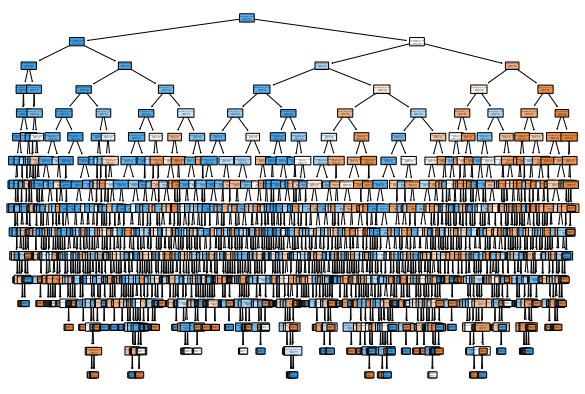

In [29]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

clf =DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_split=3,random_state=123)

clf.fit(X_train, y_train)
plt.figure(figsize=(10, 7))
plot_tree(clf, filled=True, rounded=True,class_names=['0','1'],feature_names= features) 

plt.show()
#plt.savefig('6.png', dpi=600)
#plt.savefig('DT_data1.pdf')

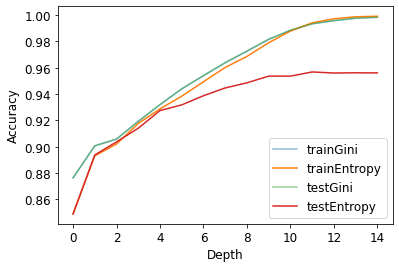

In [30]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm_notebook

trainGini = []
testGini = []
trainEntropy = []
testEntropy = []
depth_settings = range(1, 16)

for k in depth_settings:
    #using gini to training dataset
    dt = DecisionTreeClassifier(criterion='gini', max_depth=k, min_samples_split=3,
    random_state=123)
    dt.fit(X_train, y_train)
    
    # accuracy - Gini
    trainGini.append(dt.score(X_train, y_train))
    testGini.append(dt.score(X_train, y_train))
    
    # using entropy
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=k,min_samples_split=3,
    random_state=123)
    dt.fit(X_train, y_train)
    
    # accuracy - Entropy
    trainEntropy.append(dt.score(X_train, y_train))
    testEntropy.append(dt.score(X_test, y_test))
    
plt.plot(trainGini, label='trainGini', alpha=0.5)
plt.plot(trainEntropy, label='trainEntropy')
plt.plot(testGini, label='testGini', alpha=0.5)
plt.plot(testEntropy, label='testEntropy')
plt.legend()
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.show()
#plt.savefig('5.1.2DT_2.pdf')
#plt.savefig('gini_entropy.png', dpi=600)

In [31]:
#find the number of max_depth with the highest accuracy
nDepth = depth_settings[np.argmax(testGini)]
dt = DecisionTreeClassifier(max_depth = nDepth,random_state=1)
dt.fit(X_train, y_train)
print('accuracy of test set = %.4f' % dt.score(X_test,y_test))
print('Optimize max_depth = %d' % nDepth)

accuracy of test set = 0.9536
Optimize max_depth = 15


#### Random Forests 
Best hyperparameters: {'max_depth': None, 'min_samples_split': 3}
This model has already been evaluated in "4. Evaluation." Here, the visualization of 3 trees among 1000 trees is included.

In [32]:
forest = RandomForestClassifier(n_estimators=1000,
                                max_depth=None,
                                min_samples_split=3,
                                random_state=1)
forest.fit(X, y)

#Fitting it on the whole dataset 
cv_acc = cross_val_score(estimator= forest,
                         X= X,
                         y= y,
                         cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                         n_jobs=-1)

print('Kfold Accuracy: %.2f%%' % (np.mean(cv_acc)*100))

Kfold Accuracy: 97.76%


##### from sklearn import tree
from sklearn.tree import plot_tree

target = ['0','1']

fig, axes = plt.subplots(nrows = 1,ncols = 3,figsize = (10,2), dpi=900)
for index in range(0, 3):
    tree.plot_tree(forest.estimators_[index],
                   feature_names = features, 
                   class_names= target,
                   filled = True,
                   ax = axes[index])

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
#fig.savefig('3trees.png')
#fig.savefig('3trees.pdf')

### 5.2. Experiments with New Data: Data_2

The best models chosen with data_1 are applied to data_2 to check if the models perform well on the new dataset.  

In [35]:
#splitting data_2 in to train and test set 
features = ['Dead load (kN/m)', 'Live load (kN/m)', 'Yield strength (MPa)', 'Elastic modulus (MPa)', 'Sway imperfection', 'Residual stress']
X_2 = data_2[features].values 
y_2 = data_2[['Class']].values
y_2 = y_2.ravel()

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, 
                                                test_size=0.25,
                                                    random_state=123,
                                                    shuffle=True,
                                                    stratify=y_2)

print('Train/Test sizes:', X_train_2.shape, y_test_2.shape)

Train/Test sizes: (36996, 6) (12332,)


#### $k$-NN

In [36]:
#scailing data 2 for k-NN
scaler = StandardScaler()
X_train_scaled = scaler.fit(X_train_2).transform(X_train_2)
X_test_scaled = scaler.fit(X_test_2).transform(X_test_2)
X_scaled = scaler.fit(X_2).transform(X_2)

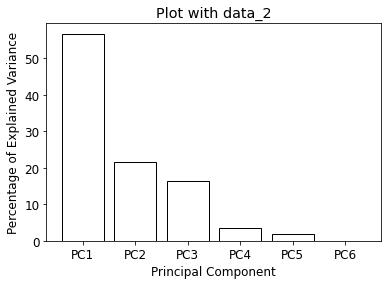

[56.7 21.6 16.4  3.5  1.8  0. ]


<Figure size 432x288 with 0 Axes>

In [37]:
#pca
data = X_2  #Need to use both X_train & X_test 

#Before we do PCA, we have to center the data 
#After centering, the average value for each feature will be 0, variance will be 1
scaled = StandardScaler().fit_transform(data.T) 

pca = PCA() 
pca.fit(scaled) 
pca_data = pca.transform(scaled) #generating coordinates for a PCA graph based on the loading scores and the scaled data 

#Calculating the percentage of variation that each principal component accounts for 
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ['PC'+ str(x) for x in range(1, len(per_var) +1)]

plt.rcParams.update({'font.size': 12})
plt.bar(x=range(1, len(per_var) +1), height=per_var, tick_label=labels, color = 'white', ec= 'black')
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Plot with data_2')
plt.show() 


plt.savefig('pca_var_2.png', dpi=600)
#plt.savefig('pca_var_2.pdf')

print(per_var)

In [38]:
#SFS
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)

#simple sequential forward selection 
sfs1 = SFS(knn, 
           k_features=3, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=0)

sfs1 = sfs1.fit(X_2, y_2)
sfs1.subsets_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.6s finished

[2020-12-17 10:41:17] Features: 1/3 -- score: 0.9695102173207915[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.6s finished

[2020-12-17 10:41:22] Features: 2/3 -- score: 0.979484268569575[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.9s finished

[2020-12-17 10:41:26] Features: 3/3 -- score: 0.9861741809925397

{1: {'feature_idx': (1,),
  'cv_scores': array([0.96951022]),
  'avg_score': 0.9695102173207915,
  'feature_names': ('1',)},
 2: {'feature_idx': (1, 2),
  'cv_scores': array([0.97948427]),
  'avg_score': 0.979484268569575,
  'feature_names': ('1', '2')},
 3: {'feature_idx': (0, 1, 2),
  'cv_scores': array([0.98617418]),
  'avg_score': 0.9861741809925397,
  'feature_names': ('0', '1', '2')}}

Here, the best feature indices are (0,1,2)

In [39]:
# Checking the feature
idx_2 = [0,1,2]
ary = np.array(features)
print(ary[idx_2])

# Assigning new names for training & test set with chosen features on the scaled data 
X_train_scaled = X_train_scaled[:,idx_2]
X_test_scaled = X_test_scaled[:, idx_2]

['Dead load (kN/m)' 'Live load (kN/m)' 'Yield strength (MPa)']


In [40]:
# knn 
knn = KNeighborsClassifier(n_neighbors=15,
                          algorithm='auto', 
                          p=2)
##cv on training 
cv_acc = cross_val_score(estimator= knn,
                         X= X_train_scaled,
                         y= y_train_2,
                         cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                         n_jobs=-1)

print('Kfold Accuracy: %.2f%%' % (np.mean(cv_acc)*100))


##fit on training & evaluate on test 

knn.fit(X_train_scaled, y_train_2)
print("Test Accuracy: %f" % knn.score(X_test_scaled, y_test_2))

Kfold Accuracy: 97.98%
Test Accuracy: 0.979565


#### Decision Tree 

Kfold Accuracy: 98.13%
Test Accuracy: 0.980944


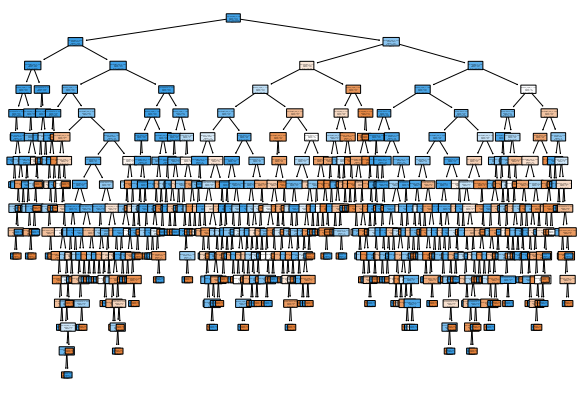

<Figure size 432x288 with 0 Axes>

In [ ]:
# fitting it on the best decisoin tree model
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=15, 
                              min_samples_split=3,
                              random_state=123)

##cv on training 
cv_acc = cross_val_score(estimator=tree,
                         X= X_train_2,
                         y= y_train_2,
                         cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                         n_jobs=-1)

print('Kfold Accuracy: %.2f%%' % (np.mean(cv_acc)*100))

tree.fit(X_train_2, y_train_2)
print("Test Accuracy: %f" % tree.score(X_test_2, y_test_2))

plt.figure(figsize=(10, 7))

plot_tree(tree, 
          filled=True, 
          rounded=True,
          class_names=['0', 
                       '1'],
          feature_names= features) 

plt.show()
plt.savefig('DT_data2.pdf')

#### Random Forests 

In [41]:
#fitting it on the best random forest model from another  cross validation after algorithm selection 

forest = RandomForestClassifier(n_estimators=1000,
                                max_depth=None,
                                min_samples_split=3,
                                random_state=1)

##cv on training 
cv_acc = cross_val_score(estimator= forest,
                         X= X_train_scaled,
                         y= y_train_2,
                         cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                         n_jobs=-1)
print('Kfold Accuracy: %.2f%%' % (np.mean(cv_acc)*100))

forest.fit(X_train_2, y_train_2)
print("Test Accuracy: % f" % forest.score(X_test_2, y_test_2))

Kfold Accuracy: 97.99%
Test Accuracy:  0.988485


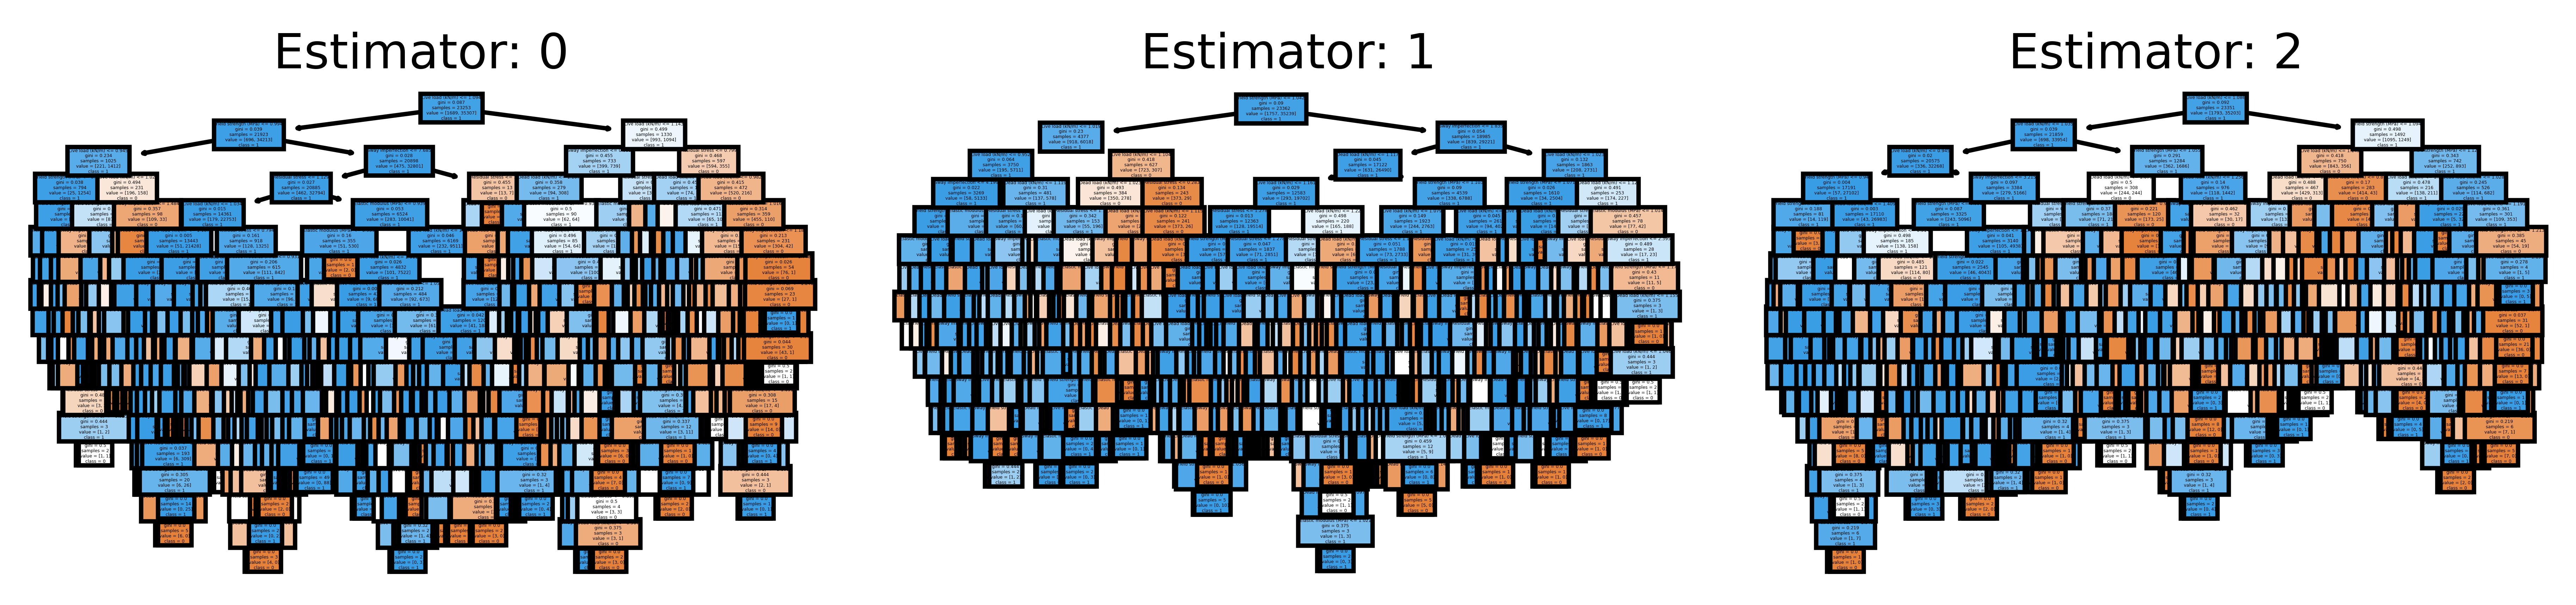

In [ ]:
from sklearn import tree

target = ['0','1']

fig, axes = plt.subplots(nrows = 1,ncols = 3,figsize = (10,2), dpi=900)
for index in range(0, 3):
    tree.plot_tree(forest.estimators_[index],
                   feature_names = features, 
                   class_names= target,
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
fig.savefig('3trees.png')
#fig.savefig('3trees.pdf')

plt.savefig('RF_data2.pdf',dpi=600)